SIMULAÇÃO DE ÓRBITA DE ASTEROIDE
Análise de Risco de Colisão com a Terra

Iniciando simulação...
Tempo total: 365 dias (8760 passos)
Passo de tempo: 3600 segundos
Energia inicial: -2.65e+33 J

Dia 0.0 | Distância Terra-Asteroide: 0.5829 UA | Erro Energia: 0.0000%
Dia 8.4 | Distância Terra-Asteroide: 0.5555 UA | Erro Energia: 0.0000%
Dia 16.7 | Distância Terra-Asteroide: 0.5390 UA | Erro Energia: 0.0000%
Dia 25.0 | Distância Terra-Asteroide: 0.5346 UA | Erro Energia: 0.0000%
Dia 33.4 | Distância Terra-Asteroide: 0.5428 UA | Erro Energia: 0.0000%
Dia 41.7 | Distância Terra-Asteroide: 0.5632 UA | Erro Energia: 0.0000%
Dia 50.0 | Distância Terra-Asteroide: 0.5951 UA | Erro Energia: 0.0000%
Dia 58.4 | Distância Terra-Asteroide: 0.6369 UA | Erro Energia: 0.0000%
Dia 66.7 | Distância Terra-Asteroide: 0.6873 UA | Erro Energia: 0.0000%
Dia 75.0 | Distância Terra-Asteroide: 0.7448 UA | Erro Energia: 0.0000%
Dia 83.4 | Distância Terra-Asteroide: 0.8082 UA | Erro Energia: 0.0000%
Dia 91.7 | Distân

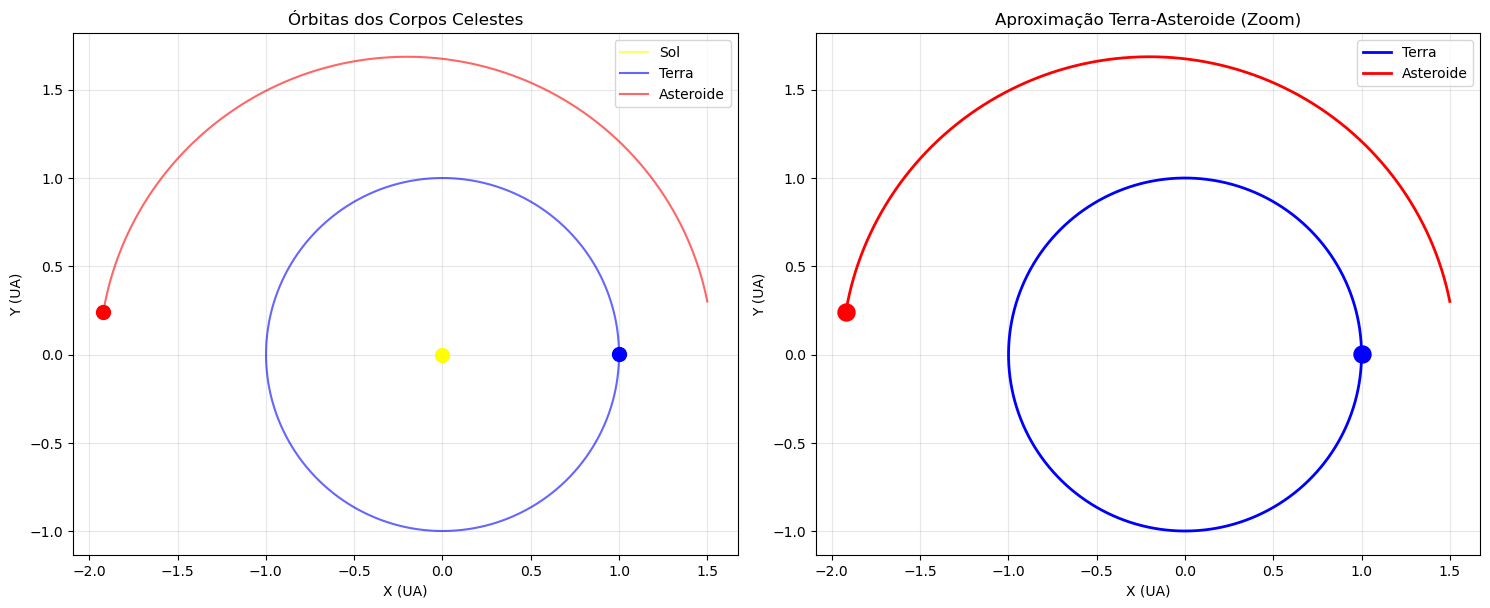


Simulação finalizada com sucesso!


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import json
from dataclasses import dataclass
from typing import List, Tuple

# Constantes físicas
G = 6.67430e-11  # Constante gravitacional (m^3 kg^-1 s^-2)
UA = 1.496e11    # Unidade Astronômica em metros
DIA = 86400      # Segundos em um dia

@dataclass
class CorpoCeleste:
    """Estrutura para armazenar propriedades de um corpo celeste"""
    nome: str
    massa: float
    posicao: np.ndarray  # [x, y, z]
    velocidade: np.ndarray  # [vx, vy, vz]
    cor: str = 'blue'
    historico_posicoes: List[np.ndarray] = None
    
    def __post_init__(self):
        if self.historico_posicoes is None:
            self.historico_posicoes = []

class SimuladorOrbital:
    """Simulador de órbitas usando método Runge-Kutta de 4ª ordem"""
    
    def __init__(self, dt: float = 3600):
        self.corpos: List[CorpoCeleste] = []
        self.dt = dt  # Passo de tempo em segundos
        self.tempo_total = 0
        self.distancia_minima = float('inf')
        self.tempo_minima_distancia = 0
        
    def adicionar_corpo(self, corpo: CorpoCeleste):
        """Adiciona um corpo celeste à simulação"""
        self.corpos.append(corpo)
    
    def calcular_aceleracao(self, corpo_idx: int, posicoes: List[np.ndarray]) -> np.ndarray:
        """Calcula a aceleração gravitacional em um corpo devido aos outros"""
        aceleracao = np.zeros(3)
        corpo = self.corpos[corpo_idx]
        
        for i, outro_corpo in enumerate(self.corpos):
            if i == corpo_idx:
                continue
            
            # Vetor da diferença de posições
            r_vec = posicoes[i] - posicoes[corpo_idx]
            r_mag = np.linalg.norm(r_vec)
            
            # Evitar divisão por zero
            if r_mag < 1e6:  # 1000 km
                r_mag = 1e6
            
            # Lei da Gravitação Universal: F = G * m1 * m2 / r^2
            # a = F/m = G * m_outro / r^2
            aceleracao += G * outro_corpo.massa * r_vec / (r_mag ** 3)
        
        return aceleracao
    
    def runge_kutta_4(self) -> None:
        """Implementação do método Runge-Kutta de 4ª ordem"""
        n = len(self.corpos)
        
        # Estados atuais
        posicoes = [corpo.posicao.copy() for corpo in self.corpos]
        velocidades = [corpo.velocidade.copy() for corpo in self.corpos]
        
        # Arrays para os k's
        k1_v = [np.zeros(3) for _ in range(n)]
        k1_r = [np.zeros(3) for _ in range(n)]
        k2_v = [np.zeros(3) for _ in range(n)]
        k2_r = [np.zeros(3) for _ in range(n)]
        k3_v = [np.zeros(3) for _ in range(n)]
        k3_r = [np.zeros(3) for _ in range(n)]
        k4_v = [np.zeros(3) for _ in range(n)]
        k4_r = [np.zeros(3) for _ in range(n)]
        
        # k1
        for i in range(n):
            k1_v[i] = self.calcular_aceleracao(i, posicoes)
            k1_r[i] = velocidades[i]
        
        # k2
        pos_temp = [posicoes[i] + 0.5 * self.dt * k1_r[i] for i in range(n)]
        vel_temp = [velocidades[i] + 0.5 * self.dt * k1_v[i] for i in range(n)]
        for i in range(n):
            k2_v[i] = self.calcular_aceleracao(i, pos_temp)
            k2_r[i] = vel_temp[i]
        
        # k3
        pos_temp = [posicoes[i] + 0.5 * self.dt * k2_r[i] for i in range(n)]
        vel_temp = [velocidades[i] + 0.5 * self.dt * k2_v[i] for i in range(n)]
        for i in range(n):
            k3_v[i] = self.calcular_aceleracao(i, pos_temp)
            k3_r[i] = vel_temp[i]
        
        # k4
        pos_temp = [posicoes[i] + self.dt * k3_r[i] for i in range(n)]
        vel_temp = [velocidades[i] + self.dt * k3_v[i] for i in range(n)]
        for i in range(n):
            k4_v[i] = self.calcular_aceleracao(i, pos_temp)
            k4_r[i] = vel_temp[i]
        
        # Atualização final
        for i in range(n):
            self.corpos[i].posicao += (self.dt / 6.0) * (k1_r[i] + 2*k2_r[i] + 2*k3_r[i] + k4_r[i])
            self.corpos[i].velocidade += (self.dt / 6.0) * (k1_v[i] + 2*k2_v[i] + 2*k3_v[i] + k4_v[i])
            self.corpos[i].historico_posicoes.append(self.corpos[i].posicao.copy())
        
        self.tempo_total += self.dt
    
    def calcular_distancia_terra_asteroide(self) -> float:
        """Calcula a distância entre Terra e asteroide"""
        if len(self.corpos) < 3:
            return 0
        
        terra = self.corpos[1]  # Assumindo que Terra é o segundo corpo
        asteroide = self.corpos[2]  # Assumindo que asteroide é o terceiro corpo
        
        distancia = np.linalg.norm(asteroide.posicao - terra.posicao)
        
        # Atualizar distância mínima
        if distancia < self.distancia_minima:
            self.distancia_minima = distancia
            self.tempo_minima_distancia = self.tempo_total
        
        return distancia
    
    def calcular_energia_total(self) -> float:
        """Calcula a energia total do sistema (cinética + potencial)"""
        energia_cinetica = 0
        energia_potencial = 0
        
        # Energia cinética
        for corpo in self.corpos:
            v_mag = np.linalg.norm(corpo.velocidade)
            energia_cinetica += 0.5 * corpo.massa * v_mag ** 2
        
        # Energia potencial
        for i, corpo1 in enumerate(self.corpos):
            for j, corpo2 in enumerate(self.corpos):
                if j <= i:
                    continue
                r = np.linalg.norm(corpo1.posicao - corpo2.posicao)
                if r > 1e6:
                    energia_potencial -= G * corpo1.massa * corpo2.massa / r
        
        return energia_cinetica + energia_potencial
    
    def simular(self, tempo_total_dias: int, progresso_intervalo: int = 100):
        """Executa a simulação por um período de tempo"""
        passos_totais = int((tempo_total_dias * DIA) / self.dt)
        energia_inicial = self.calcular_energia_total()
        
        print(f"Iniciando simulação...")
        print(f"Tempo total: {tempo_total_dias} dias ({passos_totais} passos)")
        print(f"Passo de tempo: {self.dt} segundos")
        print(f"Energia inicial: {energia_inicial:.2e} J\n")
        
        for passo in range(passos_totais):
            self.runge_kutta_4()
            
            if passo % progresso_intervalo == 0:
                dias = self.tempo_total / DIA
                distancia = self.calcular_distancia_terra_asteroide()
                energia_atual = self.calcular_energia_total()
                erro_energia = abs((energia_atual - energia_inicial) / energia_inicial) * 100
                
                print(f"Dia {dias:.1f} | Distância Terra-Asteroide: {distancia/UA:.4f} UA | "
                      f"Erro Energia: {erro_energia:.4f}%")
        
        energia_final = self.calcular_energia_total()
        print(f"\n--- Simulação Concluída ---")
        print(f"Distância mínima: {self.distancia_minima/UA:.6f} UA ({self.distancia_minima/1e3:.0f} km)")
        print(f"Ocorreu no dia: {self.tempo_minima_distancia/DIA:.1f}")
        print(f"Energia final: {energia_final:.2e} J")
        print(f"Conservação de energia: {abs((energia_final-energia_inicial)/energia_inicial)*100:.4f}% de erro")

def criar_sistema_solar_com_asteroide(config_file: str = None) -> SimuladorOrbital:
    """Cria o sistema solar com Sol, Terra e asteroide"""
    simulador = SimuladorOrbital(dt=3600)  # 1 hora de passo
    
    if config_file:
        # Carregar de arquivo JSON
        with open(config_file, 'r') as f:
            config = json.load(f)
        
        sol = CorpoCeleste(
            nome="Sol",
            massa=config['sol']['massa'],
            posicao=np.array(config['sol']['posicao']),
            velocidade=np.array(config['sol']['velocidade']),
            cor='yellow'
        )
        
        terra = CorpoCeleste(
            nome="Terra",
            massa=config['terra']['massa'],
            posicao=np.array(config['terra']['posicao']),
            velocidade=np.array(config['terra']['velocidade']),
            cor='blue'
        )
        
        asteroide = CorpoCeleste(
            nome="Asteroide",
            massa=config['asteroide']['massa'],
            posicao=np.array(config['asteroide']['posicao']),
            velocidade=np.array(config['asteroide']['velocidade']),
            cor='red'
        )
    else:
        # Configuração padrão
        # Sol no centro
        sol = CorpoCeleste(
            nome="Sol",
            massa=1.989e30,  # kg
            posicao=np.array([0.0, 0.0, 0.0]),
            velocidade=np.array([0.0, 0.0, 0.0]),
            cor='yellow'
        )
        
        # Terra em órbita circular
        terra = CorpoCeleste(
            nome="Terra",
            massa=5.972e24,  # kg
            posicao=np.array([UA, 0.0, 0.0]),  # 1 UA do Sol
            velocidade=np.array([0.0, 29780.0, 0.0]),  # velocidade orbital da Terra
            cor='blue'
        )
        
        # Asteroide em trajetória de aproximação
        asteroide = CorpoCeleste(
            nome="Asteroide",
            massa=1e15,  # kg (aproximadamente 1 km de diâmetro)
            posicao=np.array([1.5 * UA, 0.3 * UA, 0.0]),
            velocidade=np.array([-5000.0, 25000.0, 0.0]),
            cor='red'
        )
    
    simulador.adicionar_corpo(sol)
    simulador.adicionar_corpo(terra)
    simulador.adicionar_corpo(asteroide)
    
    return simulador

def visualizar_orbitas(simulador: SimuladorOrbital):
    """Visualiza as órbitas dos corpos celestes"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Gráfico 1: Órbitas completas
    ax1.set_xlabel('X (UA)')
    ax1.set_ylabel('Y (UA)')
    ax1.set_title('Órbitas dos Corpos Celestes')
    ax1.grid(True, alpha=0.3)
    ax1.set_aspect('equal')
    
    for corpo in simulador.corpos:
        if len(corpo.historico_posicoes) > 0:
            posicoes = np.array(corpo.historico_posicoes)
            ax1.plot(posicoes[:, 0]/UA, posicoes[:, 1]/UA, 
                    label=corpo.nome, color=corpo.cor, alpha=0.6)
            # Posição final
            ax1.scatter(posicoes[-1, 0]/UA, posicoes[-1, 1]/UA, 
                       color=corpo.cor, s=100, zorder=5)
    
    ax1.legend()
    
    # Gráfico 2: Zoom na região Terra-Asteroide
    ax2.set_xlabel('X (UA)')
    ax2.set_ylabel('Y (UA)')
    ax2.set_title('Aproximação Terra-Asteroide (Zoom)')
    ax2.grid(True, alpha=0.3)
    ax2.set_aspect('equal')
    
    # Plotar apenas Terra e Asteroide
    for i, corpo in enumerate(simulador.corpos[1:], 1):
        if len(corpo.historico_posicoes) > 0:
            posicoes = np.array(corpo.historico_posicoes)
            ax2.plot(posicoes[:, 0]/UA, posicoes[:, 1]/UA, 
                    label=corpo.nome, color=corpo.cor, linewidth=2)
            ax2.scatter(posicoes[-1, 0]/UA, posicoes[-1, 1]/UA, 
                       color=corpo.cor, s=150, zorder=5)
    
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    

def criar_arquivo_configuracao_exemplo():
    """Cria um arquivo de configuração de exemplo"""
    config = {
        "sol": {
            "massa": 1.989e30,
            "posicao": [0.0, 0.0, 0.0],
            "velocidade": [0.0, 0.0, 0.0]
        },
        "terra": {
            "massa": 5.972e24,
            "posicao": [1.496e11, 0.0, 0.0],
            "velocidade": [0.0, 29780.0, 0.0]
        },
        "asteroide": {
            "massa": 1e15,
            "posicao": [2.244e11, 4.488e10, 0.0],
            "velocidade": [-5000.0, 25000.0, 0.0]
        }
    }
    
    with open('config_asteroide.json', 'w') as f:
        json.dump(config, f, indent=4)
    
    print("Arquivo de configuração 'config_asteroide.json' criado!")

# Programa principal
if __name__ == "__main__":
    print("=" * 60)
    print("SIMULAÇÃO DE ÓRBITA DE ASTEROIDE")
    print("Análise de Risco de Colisão com a Terra")
    print("=" * 60)
    print()
    
    # Criar sistema solar com asteroide
    simulador = criar_sistema_solar_com_asteroide()
    
    # Executar simulação (365 dias = 1 ano)
    simulador.simular(tempo_total_dias=365, progresso_intervalo=200)
    
    # Visualizar resultados
    visualizar_orbitas(simulador)
    
    print("\nSimulação finalizada com sucesso!")